# PyExtal example for CBED refinement

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import farid
from pyextal.dinfo import CBEDDiffractionInfo
from pyextal.roi import CBEDROI


from pyextal.optimize import CoarseOptimize, FineOptimize
from pyextal.gof import Chi2_multibackground
plt.rcParams['image.cmap'] = 'inferno'

pyextal package imported. Version: 0.0.1


### load data
1. load the input data
2. load the mtf for the detector
3. display the data

In [ ]:
data = np.fromfile("si04.img", dtype='<f4', offset=8).reshape(1024, 1024).byteswap()
mtf = np.load('YAG 120 CCD MTF.npy')

plt.imshow(data)

### set detector parameters
- set the detector parameters, check [Electron Detection Characteristics of a Slow-Scan CCD Camera, Imaging Plates and Film, and Electron Image Restoration](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/) for what the parameters mean
   - varB
   - delta
   - A
   - g
   - m
- background for Lucy-Richardson deconvolution (currently not used)


In [4]:
dtpar = [3.15, 4e-5, 1.2, 2.2, 0.111]
background = 38.0681229


### initialize diffraction info class
- stores dp
- initial guess of thickness
- additional tilt x and y
- geometry scaling
- .dat file path
- detector parameters
- mtf shape
- background for Lucy-Richardson deconvolution

In [ ]:
dinfo = CBEDDiffractionInfo(data, 3431.99,  0, 0, 226.7, 'Si_systematic.dat', dtpar, mtf, background,)

### region of interest parameters:
defines the region of interest for refinement
- rotation: relative to the xaxis set in .dat
- gInclude: list of g-vectors to include in the refinement
- dpCenter: of diffraction pattern for simulation as reference point
- dpSize: size of the diffraction pattern for simulation

In [6]:
rotation = 44.742
dpCenter = [250, 450]
dpSize = [500,1200]

- gx: the horizontal axis for simulation

include beam initialized
group symmetry initialized


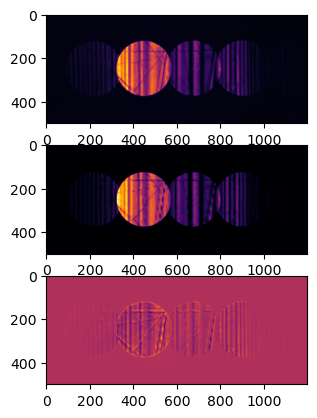

In [7]:
roi = CBEDROI(dinfo=dinfo, rotation=rotation, gx=np.array([1,-1,-1]), gInclude=[(-1,1,1),(0,0,0),(1,-1,-1),(2,-2,-2)], dpCenter=dpCenter, dpSize=dpSize) 

select the region of interest for refinement
- regions: define 3 points relative to dpCenter to defeine a parallelogram, multiple regions can be defined, [[region1_top_left, region1_top_right, region1_bottom_left, pixels],  
 [region2_top_left, region2_top_right, region2_bottom_left], ...]  
region_top_left = [row, column]  
pixels = [pixels_row, pixels_column]

- mask: whether to include the region for each reflection selected in nthgx [[region1_beam1, region1_beam2, ...], [region2_beam1, region2_beam2, ...], ...], 1 include, 0 exclude

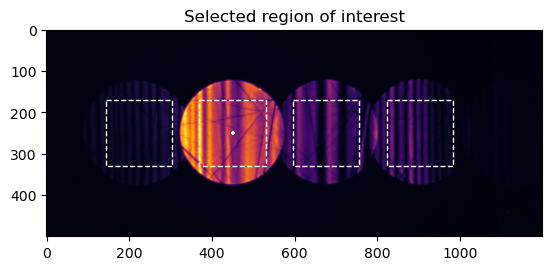

In [8]:
roi.selectROI(np.array([[[-80,-80], [-80, 80], [80,-80], [160,160]]]))
roi.displayROI()

### initialize coarse refine
- only support rectangular ROI, and only one region

In [9]:
coarse = CoarseOptimize(dinfo=dinfo, roi=roi, searchRadius=0.7, nx=60)

In [10]:
coarse.optimizeOrientationThickness()


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 3433.1703399999997, gl: 226.7, tiltY: -0.018218052064882362, tiltX: 0.0060726840216274725


In [11]:
coarse.displayCoarseSearch()

In [ ]:

roi.selectROI(np.array([
[[61.48970, -80.59588], [61.48970, 104.16463], [61.48970, -80.59588], [101, 1]], 
[[16.15227, -85.27648], [11.25240, 83.03997], [16.15227, -85.27648], [101, 1]], 
[[59.41647, -44.46745], [25.42195, -44.45989], [59.41647, -44.46745], [21, 1]], 
[[59.41647, 68.88256], [25.42195, 68.89011], [59.41647, 68.88256], [21, 1]],]),
                       mask=np.array([[1,1,1,1],[0,0,1,1],[0,0,0,1],[0,0,1,0], ]))

roi.displayROI()

### initialize fine refine for structure factor
- reflections: list of reflections to refine
- errorFunc: error function to use for refinement, define in gof.py, if developing new error function, inherit from BaseGOF ABC.
- perturbROI: allow shift or rotation or scale of the region of interest
- shift disk: allow region of interest to shift different for each beam selected by nthgx

In [14]:
fine = FineOptimize(dinfo=dinfo,
                    roi=roi,
                    reflections=[(1,-1,-1),(2,-2,-2)],
                    sfMask=np.array([[True, True], [True, False]]),
                    errorFunc=Chi2_multibackground(dinfo), 
                    perturbROI=True,
                    shiftDisk=False,
                    symUpdate=False,
                    )

# fine.getx0()

In [15]:
extal = np.array([[0.0471822, 0, 0.831778E-03, 180], 
                  [0.963641E-03, 180, 0, 0],])
fine.getx0(extal[:,::2])
fine.getRange(np.array([[[0.045, 0.0005], [0.0009,0.00]], [[0.05, 0.001],[0.0011, 0.00]]]))

setting the initial value and normalization range to:
beam: (1, -1, -1)
      lower       value       upper  
U : 4.5000000e-02   4.7182200e-02   5.0000000e-02
UA: 5.0000000e-04   8.3177800e-04   1.0000000e-03
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : 9.0000000e-04   9.6364100e-04   1.1000000e-03
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------


(1, -1, -1): U 0.0471822 UA 0.0008318
(2, -2, -2): U 0.0009636 UA 0.0000000
Chi Square background for each disk: 3.51688


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([array([[[ 109.39624 ,   73.96656 ,   55.24126 ,   47.627796,
             28.129421,   44.214115,   78.700386,  110.32234 ,
            132.41826 ,  154.47206 ,  124.53743 ,   85.96586 ,
             73.45782 ,   49.395992,   72.80916 ,  133.79439 ,
            107.547386,  105.988945,   62.481163,   45.297016,
             69.40972 ,   95.42645 ,  131.38573 ,  137.13596 ,
            144.21326 ,   91.551636,   53.98436 ,   43.45992 ,
             58.647514,   79.8623  ,  105.55121 ,  134.29573 ,
            144.68329 ,  146.23495 ,  131.84833 ,   97.98572 ,
             65.26421 ,   41.86169 ,   32.3359  ,   57.956135,
            103.78283 ,  125.46804 ,  144.0162  ,  137.71368 ,
            135.45592 ,  113.192535,   76.3919  ,   56.962902,
             52.924446,   48.56352 ,   65.694786,   89.22204 ,
             92.1285  ,   82.132675,   71.80733 ,  133.27448 ,
            143.48962 ,  145.9666  ,   89.143394,   58.94282 ,
             50.56193 ,   52.458332,  105.96425 ,  137.

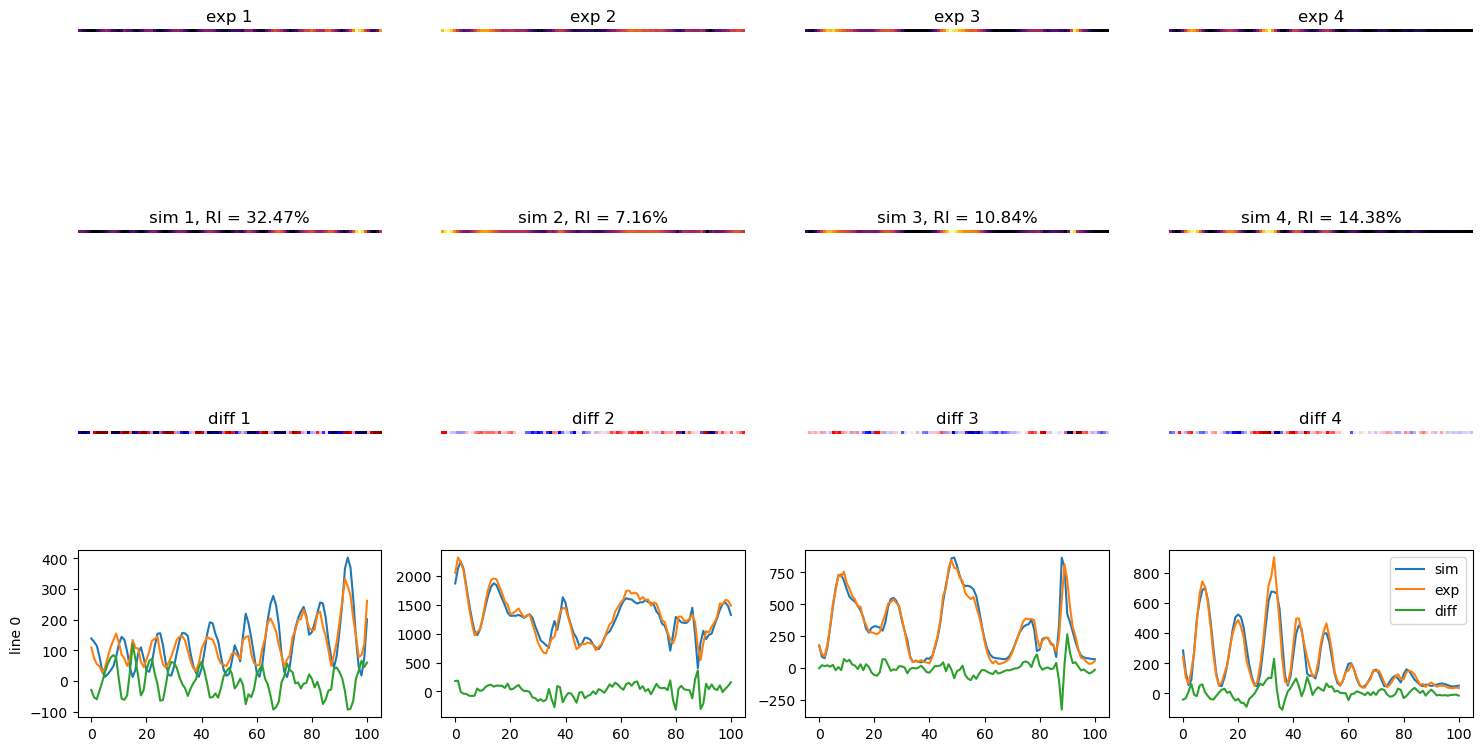

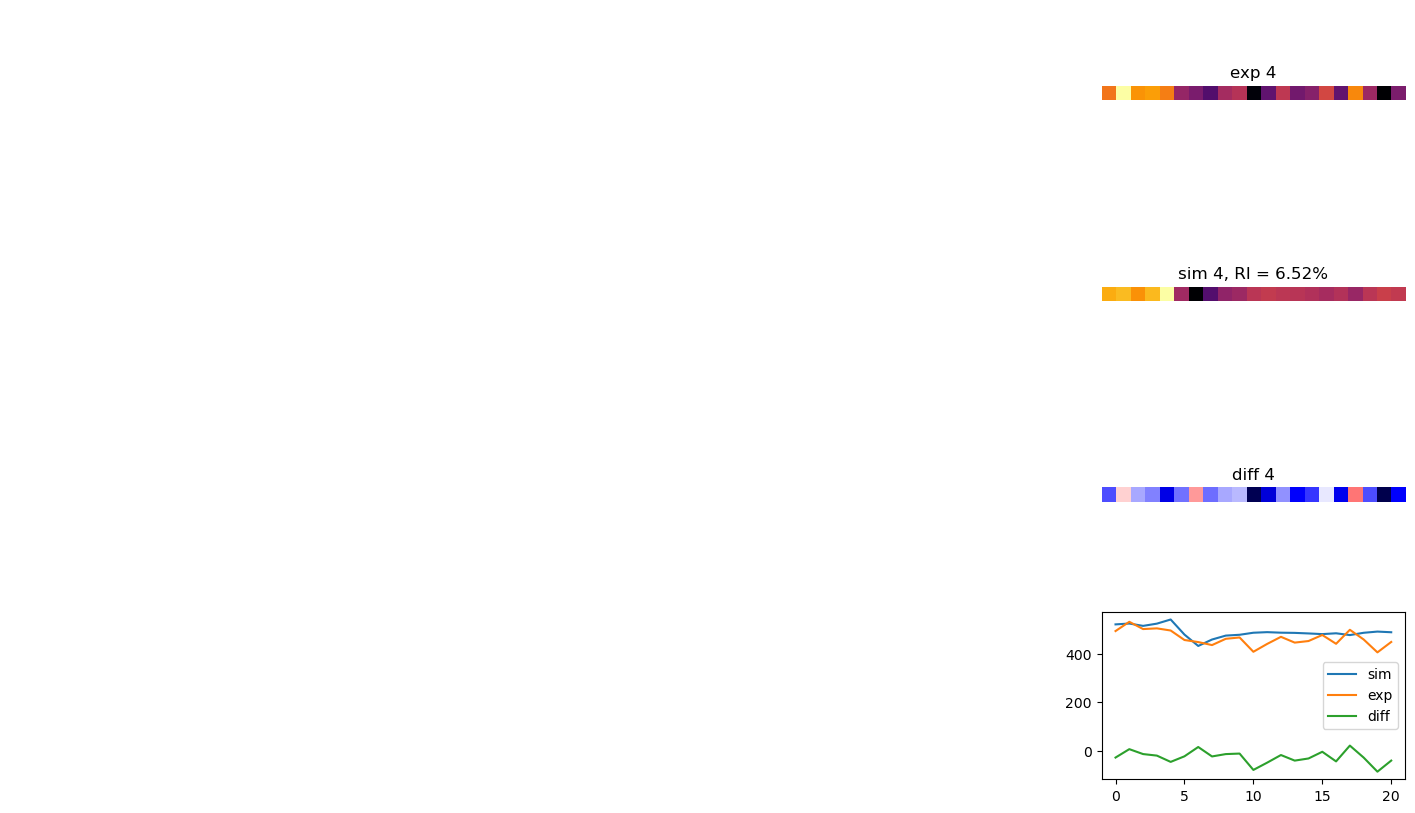

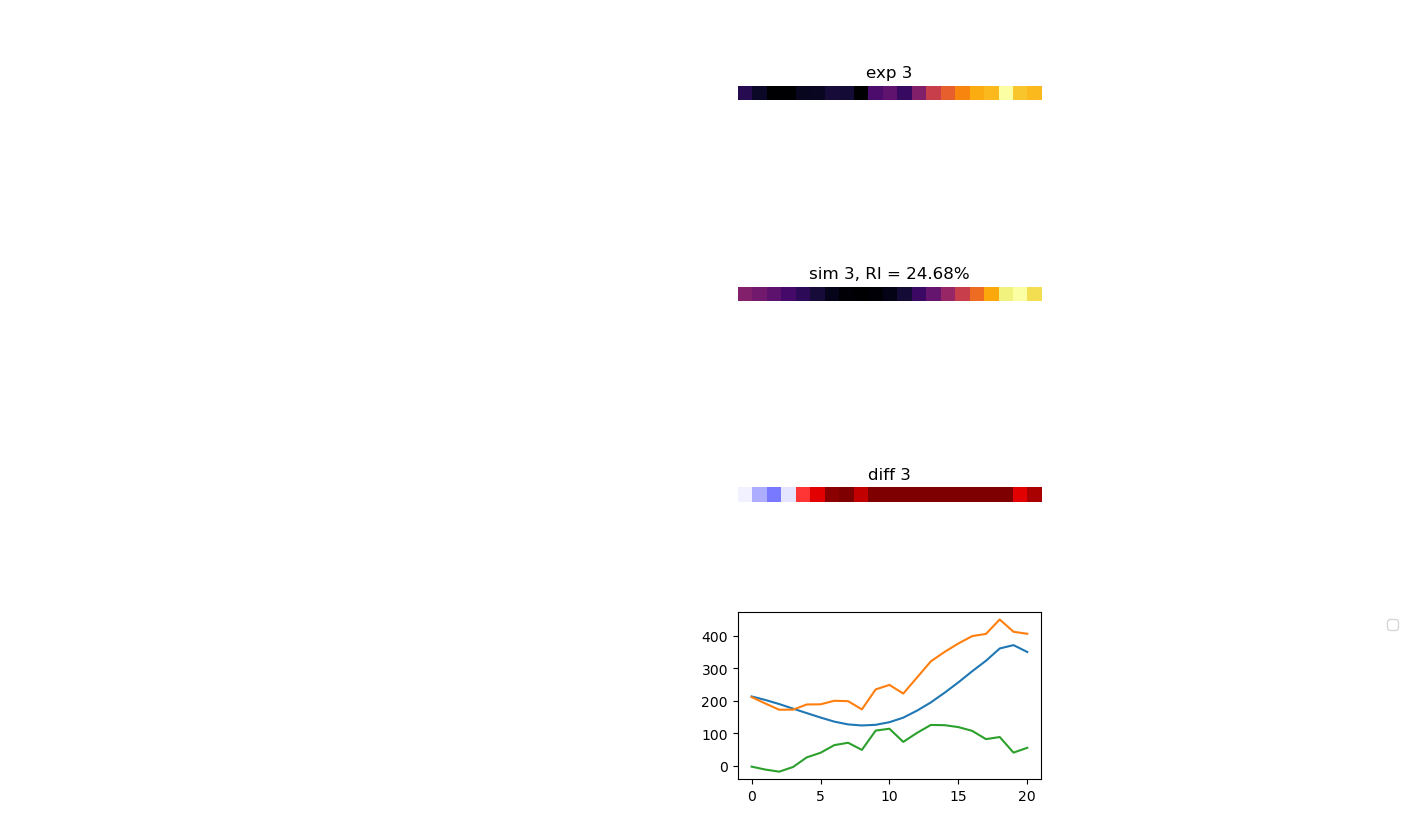

In [ ]:
fine.display([0,])

start the refinement
- x0: initial guess for the structure factor, if not provided, use the structure factor save in fine (1,1,1,1) (bird's atomic scatter factor) if no previous fine refinement

In [16]:
%matplotlib qt
fine.optimize()
# fine.optimize()

setting the initial value and normalization range to:
beam: (1, -1, -1)
      lower       value       upper  
U : 4.5000000e-02   4.7182200e-02   5.0000000e-02
UA: 5.0000000e-04   8.3177800e-04   1.0000000e-03
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : 9.0000000e-04   9.6364100e-04   1.1000000e-03
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen
/home/hcni/project/bloch-python/src/pyextal/optimize.py:656: RuntimeWarning: invalid value encountered in divide
  return ((self.x0-self.x0Range[0])/(self.x0Range[1]-self.x0Range[0]))[self.sfMask]


start optimization
normal:[[0.0471822  0.00083178]
 [0.00096364 0.        ]]
SF:
(1, -1, -1): 4.7182200e-02 8.3177800e-04
(2, -2, -2): 9.6364100e-04 0.0000000e+00
thickness: 3430.84 gl: 226.91080 rotation: 44.77882
corner: -0.00237 -0.86979
GOF: 3.08907  func eval: 227
Error: 3.063747718685963  func eval: 227
********************
SF:
(1, -1, -1): 4.7291310e-02 8.3177800e-04
(2, -2, -2): 9.6364100e-04 0.0000000e+00
thickness: 3425.48 gl: 226.84112 rotation: 44.22193
corner: 1.22121 -2.95196
GOF: 2.79851  func eval: 513
Error: 2.77556872758709  func eval: 513
********************
SF:
(1, -1, -1): 4.7182200e-02 8.4836690e-04
(2, -2, -2): 9.6364100e-04 0.0000000e+00
thickness: 3430.83 gl: 226.91446 rotation: 44.21622
corner: 1.17192 -3.05009
GOF: 2.85847  func eval: 173
Error: 2.8350354804367317  func eval: 173
********************
SF:
(1, -1, -1): 4.7182200e-02 8.3177800e-04
(2, -2, -2): 9.6682305e-04 0.0000000e+00
thickness: 3430.87 gl: 226.91331 rotation: 44.21658
corner: 1.17304 -3.050

(1, -1, -1): U 0.0473504 UA 0.0007937
(2, -2, -2): U 0.0009232 UA 0.0000000
Chi Square background for each disk: 2.77708


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([array([[[ 122.603516,   87.00329 ,   72.371346,   53.09177 ,
             25.50181 ,   51.780037,   61.017807,   97.8967  ,
            105.329384,  159.33693 ,  170.13115 ,  115.242134,
             98.43761 ,   51.90651 ,   58.070084,   92.55951 ,
            128.23131 ,   93.8825  ,   71.29088 ,   51.915596,
             67.487495,   88.19801 ,  138.54913 ,  174.19174 ,
            135.16019 ,  102.675415,   69.48671 ,   43.05283 ,
             36.499447,   70.69781 ,   91.27959 ,  120.781624,
            123.13015 ,  146.33473 ,  132.49521 ,   96.51876 ,
             77.12936 ,   52.317577,   39.6853  ,   79.50824 ,
             92.224724,  114.14242 ,  134.35925 ,  136.80196 ,
            146.2433  ,  103.56879 ,   84.94141 ,   83.56645 ,
             50.260094,   51.470497,   63.311462,   70.85064 ,
             81.03875 ,   79.73408 ,   96.99628 ,  118.62076 ,
            165.31316 ,  148.82146 ,   92.11967 ,   77.75542 ,
             40.98478 ,   58.468098,   81.75309 ,  148.

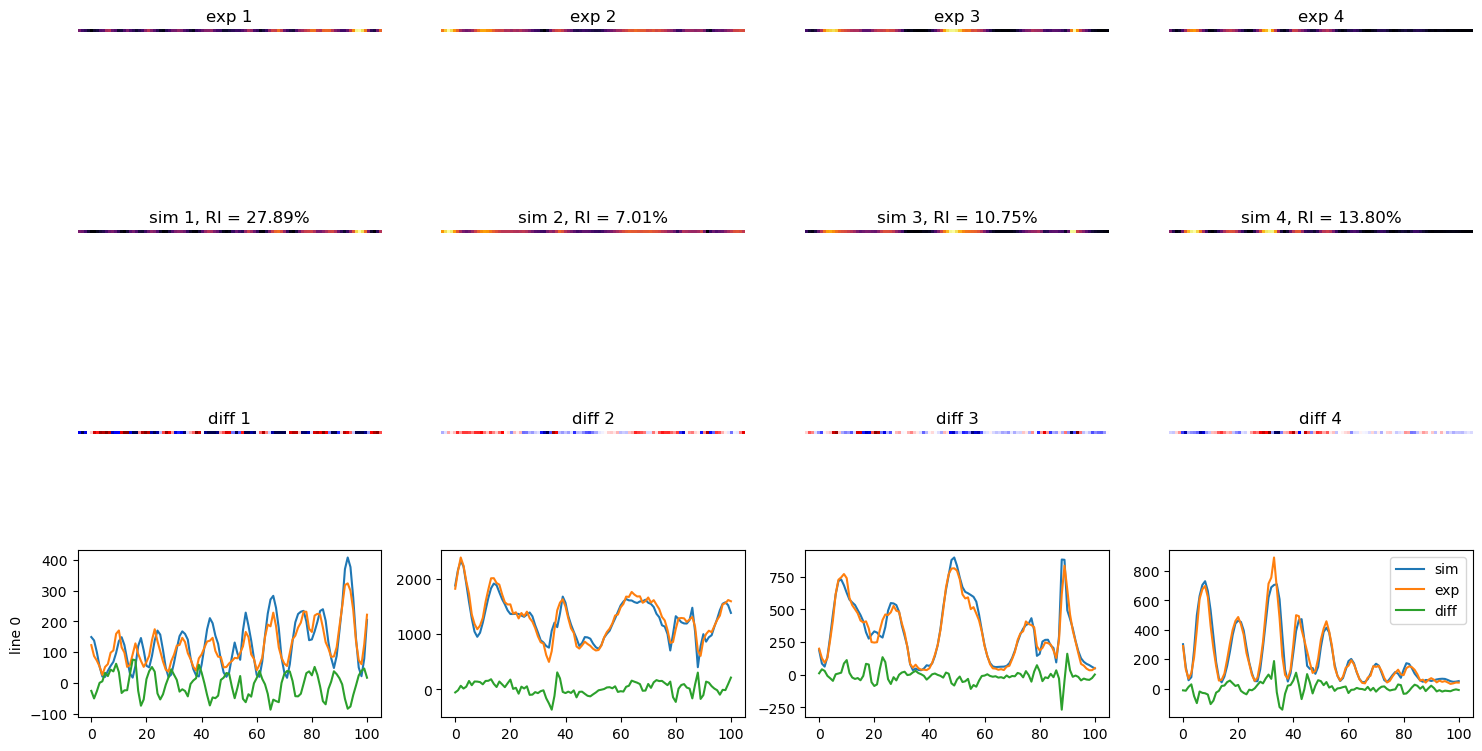

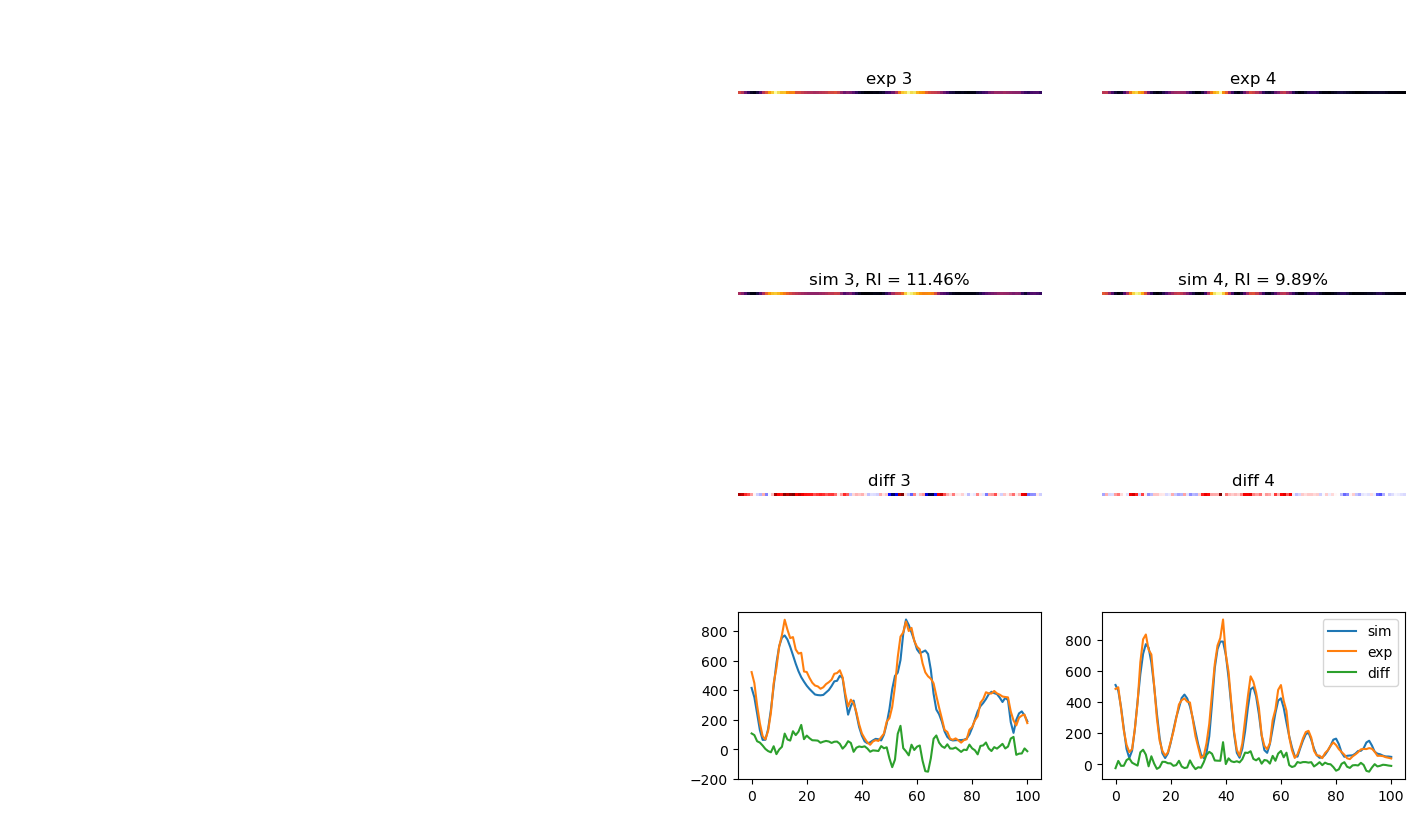

In [17]:
%matplotlib inline
fine.display([0,])

In [28]:
fine.errorFunc(fine.evaluateParam(), fine.roi.templates, fine.roi.mask)

2779.2666

In [20]:
print(f'kt: 12.1174, -12.1174, 25.7133 = {roi.transformDP(roi.kt2pixel(np.array([[12.1174, -12.1174, 25.7133]]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter+roi.allshift)}')
print(f'gl: {roi.gl} rotation: {roi.rotation}')
print(f'thickness: {fine.thickness} ')
print(f'norm:: {fine.errorFunc.scale}')
print(f'background: {fine.errorFunc.background}')


kt: 12.1174, -12.1174, 25.7133 = [[416.10777583 456.98849595]]
gl: 226.77354262586226 rotation: 44.23690197629627
thickness: 3421.6441471701332 
norm:: 1797.220458984375
background: [[ 16.015116]
 [222.49435 ]
 [ 33.66471 ]
 [ 38.898853]]


In [22]:
from pyextal.callBloch import terminate
terminate()